# Training Data Visualization Tool

Interactive visualization tool for analyzing energy consumption data across customer groups.

## Features
- Load and preprocess training data
- Interactive customer group selection
- Time pattern analysis (hourly, daily, weekly, monthly)
- Group comparison visualizations
- Statistical summaries

## 1. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import ipywidgets as widgets
from IPython.display import display
import warnings

warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Increase default figure size
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [2]:
# Load the training data from Excel file (multi-sheet structure)
print("Loading training data from Excel file...")
print("This file contains 3 sheets: groups, training_consumption, and training_prices")
print()

# Load consumption data (main data with 32,856 hourly records)
df = pd.read_excel('20251111_JUNCTION_training.xlsx', sheet_name='training_consumption')

# Load group metadata (112 customer groups with regional/demographic info)
groups_df = pd.read_excel('20251111_JUNCTION_training.xlsx', sheet_name='groups')

# Load electricity prices (hourly EUR/MWh prices)
prices_df = pd.read_excel('20251111_JUNCTION_training.xlsx', sheet_name='training_prices')

print(f"✓ Consumption data loaded: {len(df):,} rows, {len(df.columns)} columns")
print(f"  Date range: {df['measured_at'].min()} to {df['measured_at'].max()}")
print(f"  Customer groups (columns): {df.columns[1:11].tolist()}... ({len(df.columns)-1} total groups)")
print()
print(f"✓ Group metadata loaded: {len(groups_df)} customer groups")
print(f"✓ Price data loaded: {len(prices_df):,} hourly price records")
print()
print("Data loaded successfully!")

Loading training data from Excel file...
This file contains 3 sheets: groups, training_consumption, and training_prices

✓ Consumption data loaded: 32,856 rows, 113 columns
  Date range: 2021-01-01T00:00:00.000Z to 2024-09-30T23:00:00.000Z
  Customer groups (columns): [28, 29, 30, 36, 37, 38, 39, 40, 41, 42]... (112 total groups)

✓ Group metadata loaded: 112 customer groups
✓ Price data loaded: 32,880 hourly price records

Data loaded successfully!


## 2. Data Preprocessing

In [3]:
# Convert measured_at to datetime
df['measured_at'] = pd.to_datetime(df['measured_at'])

# Set measured_at as index
df.set_index('measured_at', inplace=True)

# Extract time features for pattern analysis
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['day_name'] = df.index.day_name()
df['date'] = df.index.date
df['month'] = df.index.month
df['month_name'] = df.index.month_name()
df['week'] = df.index.isocalendar().week

# Get list of customer group columns (all numeric columns except time features)
time_features = ['hour', 'day_of_week', 'day_name', 'date', 'month', 'month_name', 'week']
customer_groups = [col for col in df.columns if col not in time_features]

print(f"✓ Data preprocessed successfully")
print(f"✓ Found {len(customer_groups)} customer groups")
print(f"\nCustomer groups: {customer_groups[:20]}..." if len(customer_groups) > 20 else f"\nCustomer groups: {customer_groups}")
print(f"\nData shape: {df.shape}")
print(f"\nSample data:")
df.head()

✓ Data preprocessed successfully
✓ Found 112 customer groups

Customer groups: [28, 29, 30, 36, 37, 38, 39, 40, 41, 42, 43, 73, 74, 76, 116, 149, 150, 151, 152, 157]...

Data shape: (32856, 119)

Sample data:


,28,29,30,36,37,38,39,40,41,42,...,738,740,741,hour,day_of_week,day_name,date,month,month_name,week
measured_at,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00+00:00,7.010736,0.198555,1.192911,0.673303,0.170359,0.696948,0.147846,0.162057,0.755435,0.159639,...,1.083489,0.191345,1.104781,0,4,Friday,2021-01-01,1,January,53
2021-01-01 01:00:00+00:00,6.600845,0.189258,1.108660,0.641161,0.158715,0.653563,0.135761,0.149332,0.707493,0.153601,...,1.008406,0.190489,1.055113,1,4,Friday,2021-01-01,1,January,53
2021-01-01 02:00:00+00:00,6.468329,0.188044,1.088216,0.651150,0.153970,0.625163,0.131285,0.142122,0.667717,0.148758,...,1.005489,0.187021,1.049694,2,4,Friday,2021-01-01,1,January,53
2021-01-01 03:00:00+00:00,6.712097,0.188575,1.142844,0.659185,0.150787,0.633014,0.126051,0.133534,0.633343,0.153934,...,1.005327,0.186134,1.046279,3,4,Friday,2021-01-01,1,January,53
2021-01-01 04:00:00+00:00,6.418159,0.196142,1.163408,0.683347,0.161964,0.660679,0.127876,0.136546,0.661265,0.163658,...,1.015701,0.193971,1.096392,4,4,Friday,2021-01-01,1,January,53


## 3. Interactive Customer Group Selector

In [4]:
# Create interactive widgets for group selection
group_selector = widgets.SelectMultiple(
    options=customer_groups,
    value=[customer_groups[0]] if customer_groups else [],
    description='Customer Groups:',
    disabled=False,
    rows=10,
    layout=widgets.Layout(width='400px')
)

date_range = widgets.SelectionRangeSlider(
    options=[pd.Timestamp(d).strftime('%Y-%m-%d') for d in sorted(df['date'].unique())],
    index=(0, len(df['date'].unique())-1),
    description='Date Range:',
    disabled=False,
    layout=widgets.Layout(width='600px')
)

print("Select customer groups and date range for analysis:")
display(group_selector)
display(date_range)

Select customer groups and date range for analysis:


SelectMultiple(description='Customer Groups:', index=(0,), layout=Layout(width='400px'), options=(28, 29, 30, …

SelectionRangeSlider(description='Date Range:', index=(0, 1368), layout=Layout(width='600px'), options=('2021-…

In [18]:
# Helper function to get filtered data based on selections
def get_filtered_data():
    selected_groups = list(group_selector.value)
    start_date, end_date = date_range.value
    
    # Filter by date range
    mask = (df.index >= start_date) & (df.index <= end_date)
    filtered_df = df.loc[mask]
    
    return filtered_df, selected_groups

print("Filter helper function created.")

Filter helper function created.


## 4. Time Pattern Visualizations

### 4.1 Hourly Patterns (24-Hour Analysis)

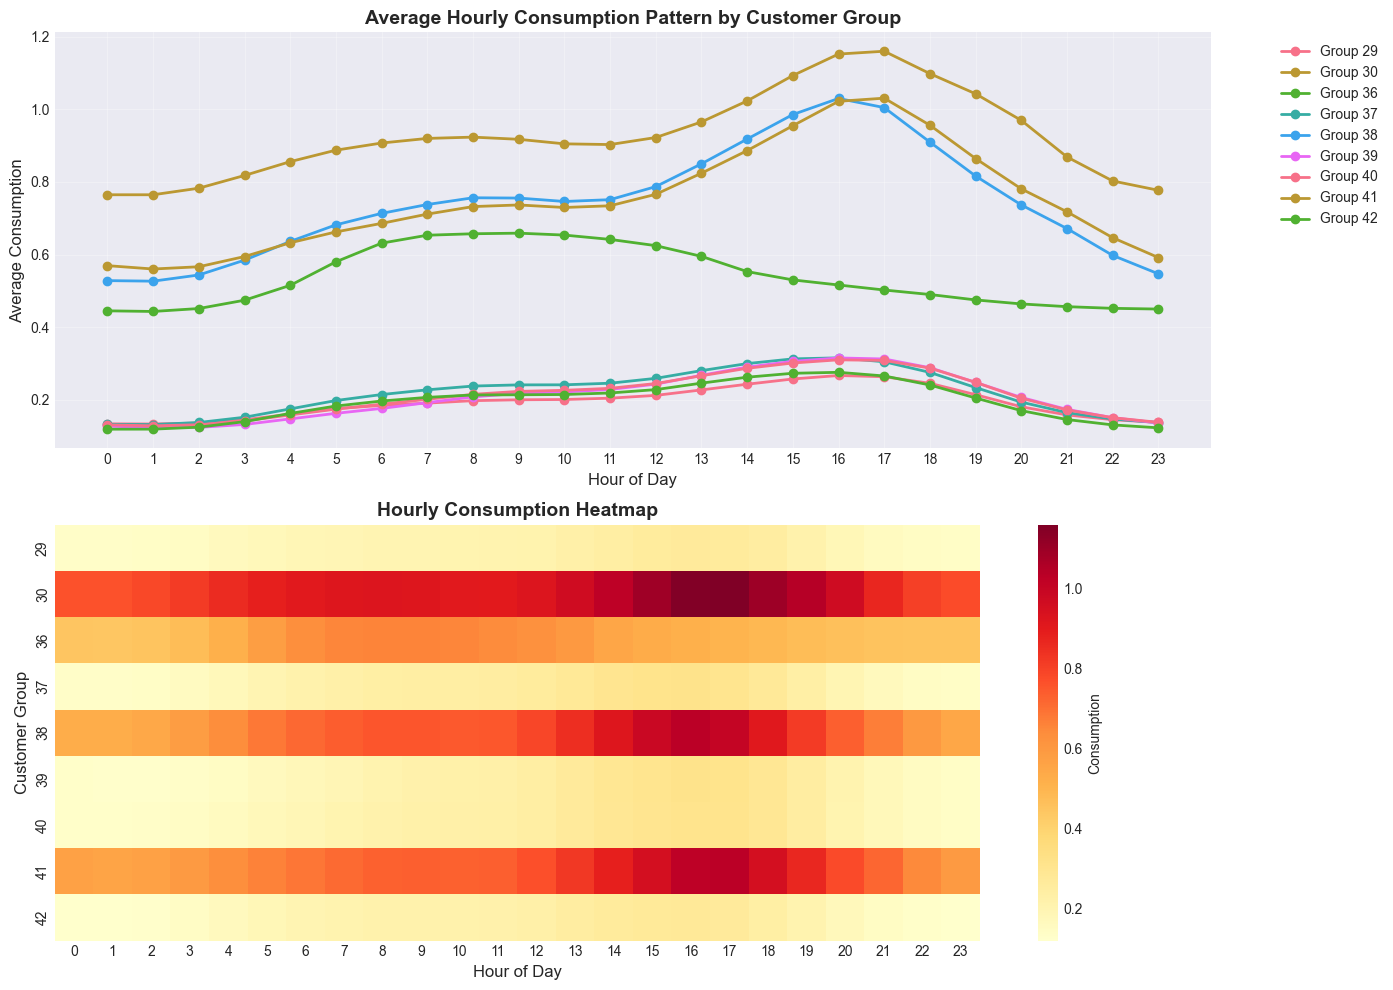


📊 Analyzed 9 customer group(s) across 32833 data points


In [19]:
# Hourly pattern analysis
filtered_df, selected_groups = get_filtered_data()

if not selected_groups:
    print("⚠️  Please select at least one customer group above.")
else:
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Plot 1: Average consumption by hour for selected groups
    hourly_avg = filtered_df.groupby('hour')[selected_groups].mean()
    
    for group in selected_groups:
        axes[0].plot(hourly_avg.index, hourly_avg[group], marker='o', label=f'Group {group}', linewidth=2)
    
    axes[0].set_xlabel('Hour of Day', fontsize=12)
    axes[0].set_ylabel('Average Consumption', fontsize=12)
    axes[0].set_title('Average Hourly Consumption Pattern by Customer Group', fontsize=14, fontweight='bold')
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xticks(range(24))
    
    # Plot 2: Heatmap of hourly patterns
    if len(selected_groups) <= 10:  # Only show heatmap if not too many groups
        hourly_data = hourly_avg[selected_groups].T
        sns.heatmap(hourly_data, ax=axes[1], cmap='YlOrRd', annot=False, cbar_kws={'label': 'Consumption'})
        axes[1].set_xlabel('Hour of Day', fontsize=12)
        axes[1].set_ylabel('Customer Group', fontsize=12)
        axes[1].set_title('Hourly Consumption Heatmap', fontsize=14, fontweight='bold')
    else:
        axes[1].text(0.5, 0.5, 'Too many groups selected for heatmap\n(max 10)', 
                    ha='center', va='center', transform=axes[1].transAxes, fontsize=14)
        axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Analyzed {len(selected_groups)} customer group(s) across {len(filtered_df)} data points")

### 4.2 Daily Trends Over Time

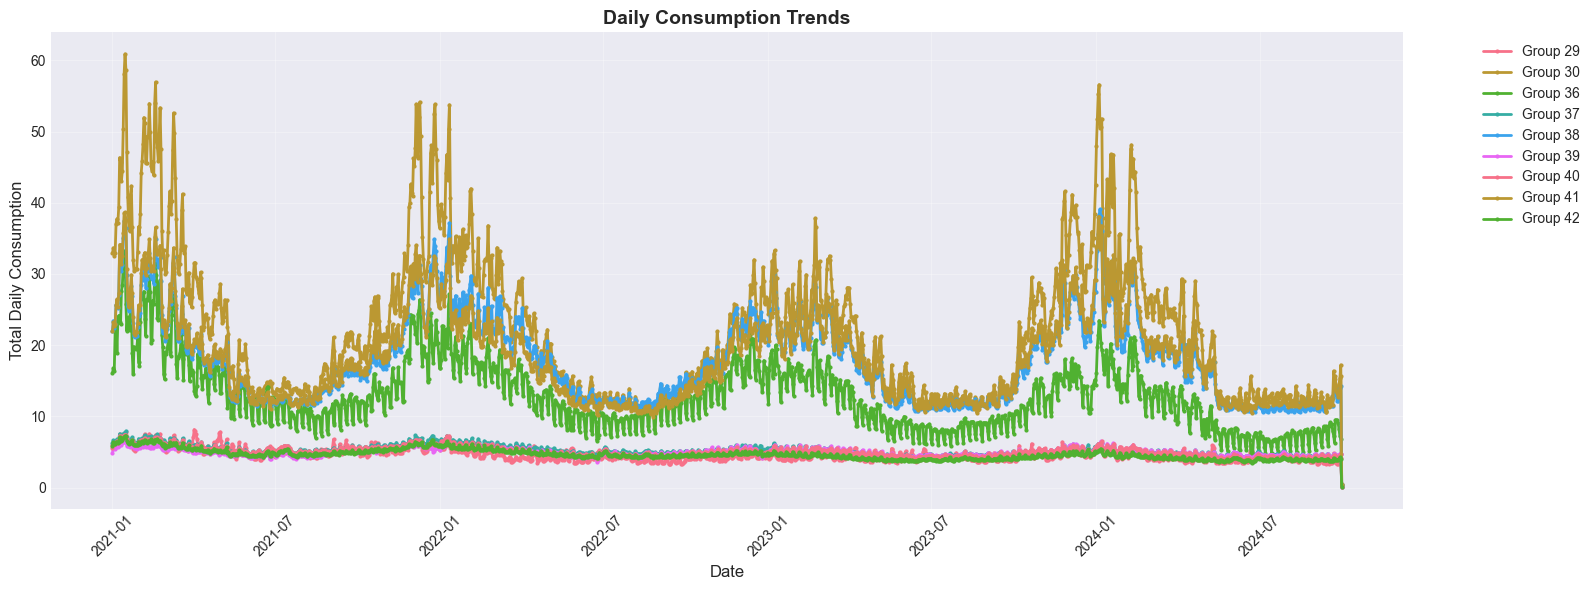


📊 Showing daily trends from 2021-01-01 to 2024-09-30


In [20]:
# Daily trends analysis
filtered_df, selected_groups = get_filtered_data()

if not selected_groups:
    print("⚠️  Please select at least one customer group above.")
else:
    # Aggregate by date
    daily_data = filtered_df.groupby('date')[selected_groups].sum()
    
    fig, ax = plt.subplots(figsize=(16, 6))
    
    for group in selected_groups:
        ax.plot(daily_data.index, daily_data[group], marker='.', label=f'Group {group}', linewidth=2, markersize=4)
    
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Total Daily Consumption', fontsize=12)
    ax.set_title('Daily Consumption Trends', fontsize=14, fontweight='bold')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Showing daily trends from {daily_data.index.min()} to {daily_data.index.max()}")

### 4.3 Weekly Patterns (Day of Week Analysis)

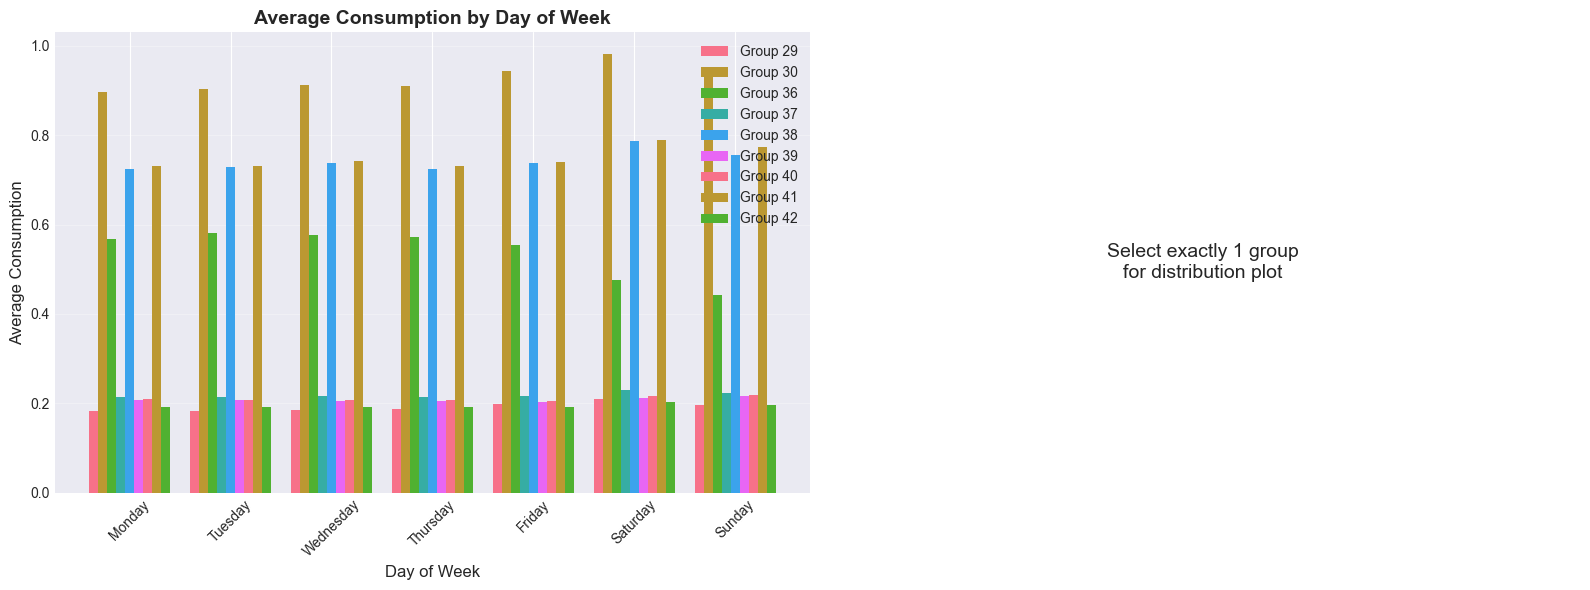


📊 Weekly pattern analysis complete


In [21]:
# Day of week pattern analysis
filtered_df, selected_groups = get_filtered_data()

if not selected_groups:
    print("⚠️  Please select at least one customer group above.")
else:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Average by day of week
    dow_avg = filtered_df.groupby('day_name')[selected_groups].mean()
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    dow_avg = dow_avg.reindex(day_order)
    
    x = np.arange(len(day_order))
    width = 0.8 / len(selected_groups) if len(selected_groups) > 0 else 0.8
    
    for i, group in enumerate(selected_groups):
        axes[0].bar(x + i * width, dow_avg[group], width, label=f'Group {group}')
    
    axes[0].set_xlabel('Day of Week', fontsize=12)
    axes[0].set_ylabel('Average Consumption', fontsize=12)
    axes[0].set_title('Average Consumption by Day of Week', fontsize=14, fontweight='bold')
    axes[0].set_xticks(x + width * (len(selected_groups) - 1) / 2)
    axes[0].set_xticklabels(day_order, rotation=45)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Plot 2: Box plot showing distribution
    if len(selected_groups) == 1:
        group = selected_groups[0]
        box_data = [filtered_df[filtered_df['day_name'] == day][group].values for day in day_order]
        axes[1].boxplot(box_data, labels=day_order)
        axes[1].set_xlabel('Day of Week', fontsize=12)
        axes[1].set_ylabel('Consumption Distribution', fontsize=12)
        axes[1].set_title(f'Consumption Distribution by Day (Group {group})', fontsize=14, fontweight='bold')
        axes[1].grid(True, alpha=0.3, axis='y')
        plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45)
    else:
        axes[1].text(0.5, 0.5, 'Select exactly 1 group\nfor distribution plot', 
                    ha='center', va='center', transform=axes[1].transAxes, fontsize=14)
        axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Weekly pattern analysis complete")

### 4.4 Monthly Aggregations

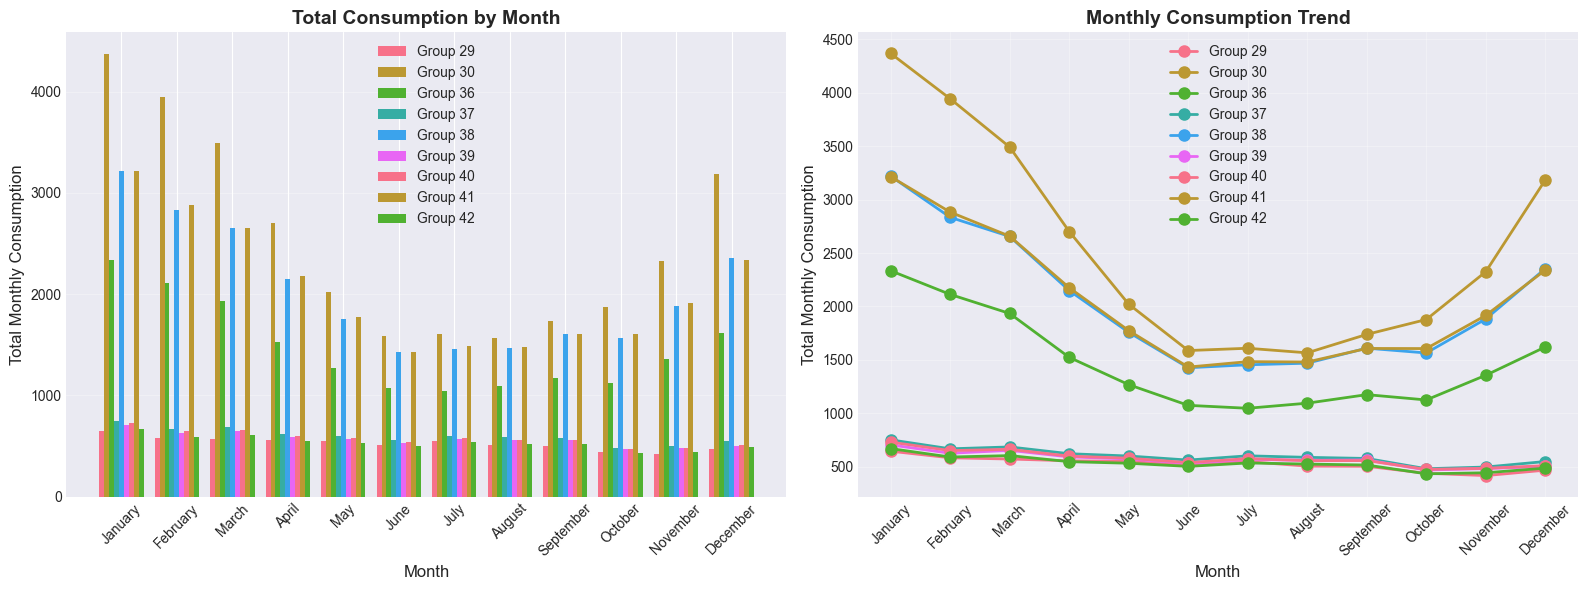


📊 Monthly analysis showing data for: January, February, March, April, May, June, July, August, September, October, November, December


In [22]:
# Monthly pattern analysis
filtered_df, selected_groups = get_filtered_data()

if not selected_groups:
    print("⚠️  Please select at least one customer group above.")
else:
    # Aggregate by month
    monthly_data = filtered_df.groupby('month_name')[selected_groups].sum()
    month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                   'July', 'August', 'September', 'October', 'November', 'December']
    # Reindex with only months that exist in data
    existing_months = [m for m in month_order if m in monthly_data.index]
    monthly_data = monthly_data.reindex(existing_months)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Bar chart of monthly totals
    x = np.arange(len(existing_months))
    width = 0.8 / len(selected_groups) if len(selected_groups) > 0 else 0.8
    
    for i, group in enumerate(selected_groups):
        axes[0].bar(x + i * width, monthly_data[group], width, label=f'Group {group}')
    
    axes[0].set_xlabel('Month', fontsize=12)
    axes[0].set_ylabel('Total Monthly Consumption', fontsize=12)
    axes[0].set_title('Total Consumption by Month', fontsize=14, fontweight='bold')
    axes[0].set_xticks(x + width * (len(selected_groups) - 1) / 2)
    axes[0].set_xticklabels(existing_months, rotation=45)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Plot 2: Line chart for trend
    for group in selected_groups:
        axes[1].plot(existing_months, monthly_data[group], marker='o', label=f'Group {group}', linewidth=2, markersize=8)
    
    axes[1].set_xlabel('Month', fontsize=12)
    axes[1].set_ylabel('Total Monthly Consumption', fontsize=12)
    axes[1].set_title('Monthly Consumption Trend', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Monthly analysis showing data for: {', '.join(existing_months)}")

## 5. Group Comparison Charts

### 5.1 Side-by-Side Time Series Comparison

In [23]:
# Detailed time series comparison
filtered_df, selected_groups = get_filtered_data()

if not selected_groups:
    print("⚠️  Please select at least one customer group above.")
elif len(selected_groups) > 6:
    print("⚠️  Too many groups selected. Please select 6 or fewer groups for detailed comparison.")
else:
    n_groups = len(selected_groups)
    fig, axes = plt.subplots(n_groups, 1, figsize=(16, 4 * n_groups), sharex=True)
    
    if n_groups == 1:
        axes = [axes]
    
    for i, group in enumerate(selected_groups):
        axes[i].plot(filtered_df.index, filtered_df[group], linewidth=1.5, color=f'C{i}')
        axes[i].set_ylabel('Consumption', fontsize=11)
        axes[i].set_title(f'Customer Group {group} - Detailed Time Series', fontsize=12, fontweight='bold')
        axes[i].grid(True, alpha=0.3)
        
        # Add summary statistics
        mean_val = filtered_df[group].mean()
        max_val = filtered_df[group].max()
        min_val = filtered_df[group].min()
        axes[i].axhline(y=mean_val, color='red', linestyle='--', alpha=0.7, linewidth=1, label=f'Mean: {mean_val:.2f}')
        axes[i].legend(loc='upper right')
    
    axes[-1].set_xlabel('Time', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Detailed comparison of {len(selected_groups)} customer group(s)")

⚠️  Too many groups selected. Please select 6 or fewer groups for detailed comparison.


### 5.2 Comparative Statistics Visualization

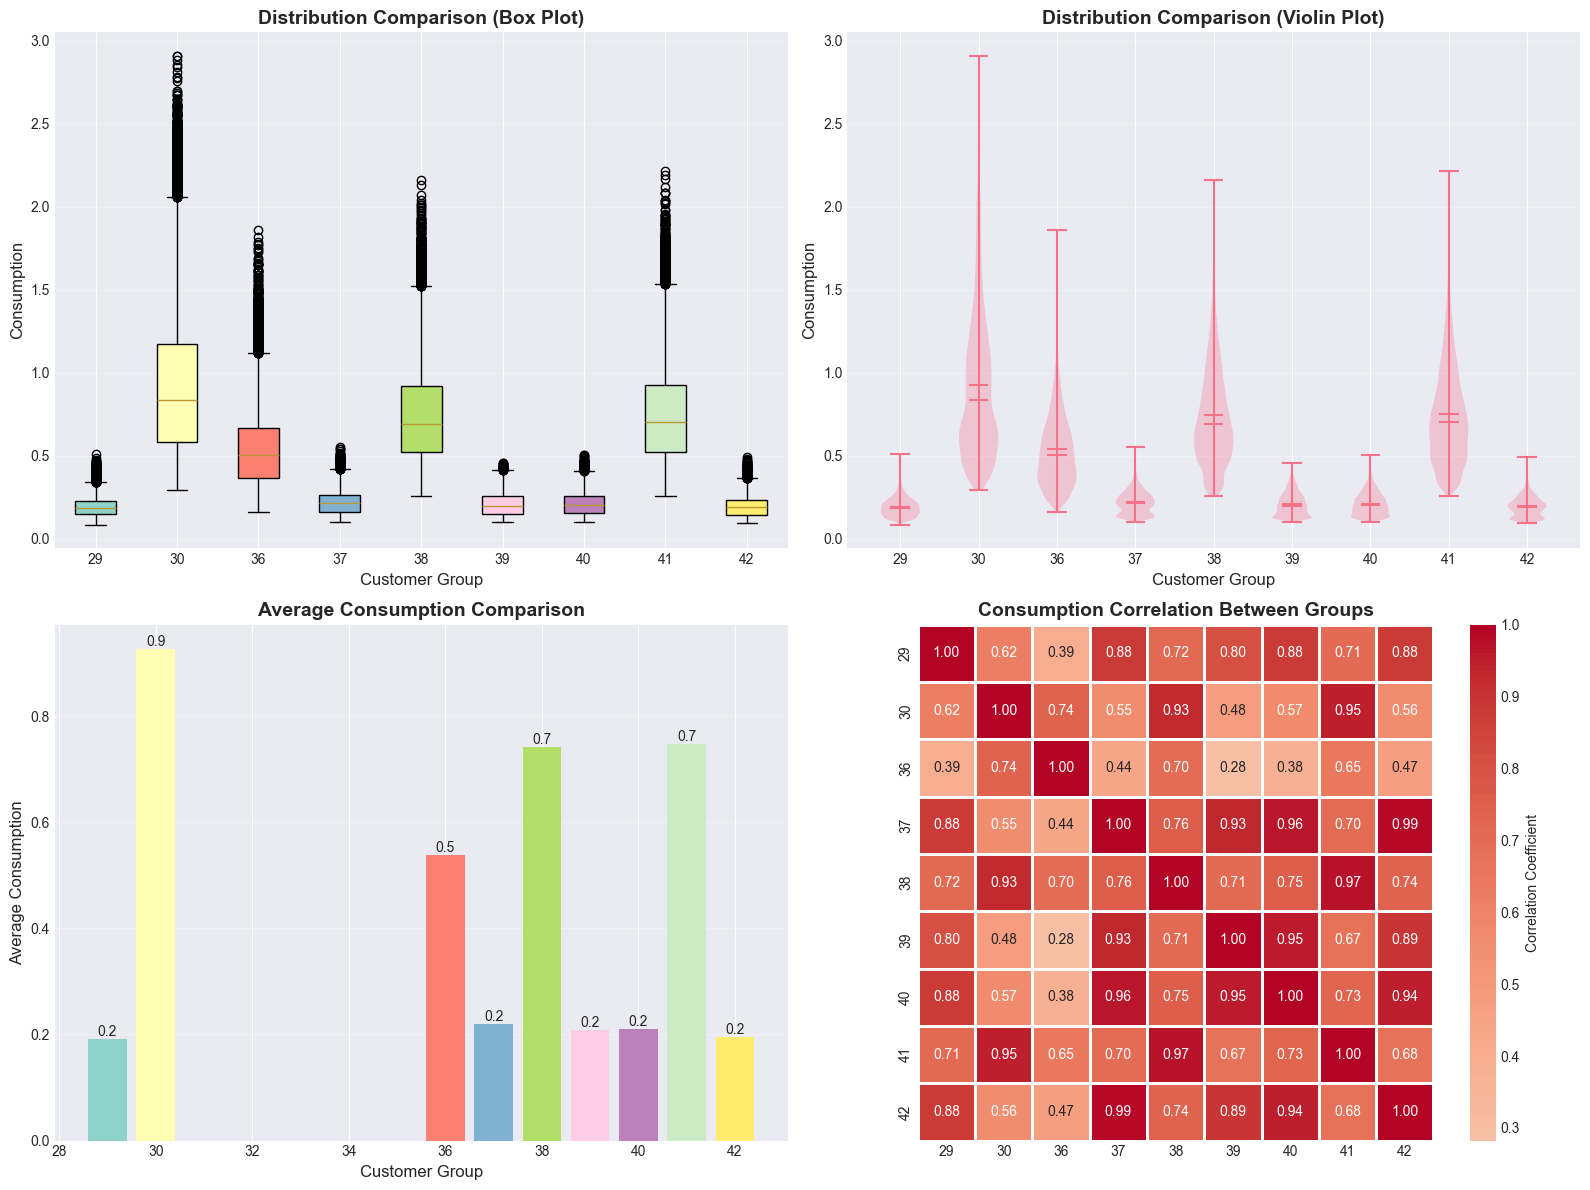


📊 Statistical comparison of 9 groups complete


In [24]:
# Comparative statistics between groups
filtered_df, selected_groups = get_filtered_data()

if not selected_groups:
    print("⚠️  Please select at least one customer group above.")
elif len(selected_groups) == 1:
    print("⚠️  Please select at least 2 groups for comparison.")
else:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Box plot comparison
    box_data = [filtered_df[group].values for group in selected_groups]
    bp = axes[0, 0].boxplot(box_data, labels=selected_groups, patch_artist=True)
    for patch, color in zip(bp['boxes'], plt.cm.Set3(np.linspace(0, 1, len(selected_groups)))):
        patch.set_facecolor(color)
    axes[0, 0].set_ylabel('Consumption', fontsize=12)
    axes[0, 0].set_xlabel('Customer Group', fontsize=12)
    axes[0, 0].set_title('Distribution Comparison (Box Plot)', fontsize=14, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    
    # Plot 2: Violin plot
    positions = np.arange(len(selected_groups))
    parts = axes[0, 1].violinplot(box_data, positions=positions, showmeans=True, showmedians=True)
    axes[0, 1].set_xticks(positions)
    axes[0, 1].set_xticklabels(selected_groups)
    axes[0, 1].set_ylabel('Consumption', fontsize=12)
    axes[0, 1].set_xlabel('Customer Group', fontsize=12)
    axes[0, 1].set_title('Distribution Comparison (Violin Plot)', fontsize=14, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # Plot 3: Average consumption comparison
    avg_consumption = [filtered_df[group].mean() for group in selected_groups]
    bars = axes[1, 0].bar(selected_groups, avg_consumption, color=plt.cm.Set3(np.linspace(0, 1, len(selected_groups))))
    axes[1, 0].set_ylabel('Average Consumption', fontsize=12)
    axes[1, 0].set_xlabel('Customer Group', fontsize=12)
    axes[1, 0].set_title('Average Consumption Comparison', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, val in zip(bars, avg_consumption):
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                       f'{val:.1f}', ha='center', va='bottom', fontsize=10)
    
    # Plot 4: Correlation heatmap
    if len(selected_groups) >= 2:
        correlation_matrix = filtered_df[selected_groups].corr()
        sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                   center=0, ax=axes[1, 1], square=True, linewidths=1,
                   cbar_kws={'label': 'Correlation Coefficient'})
        axes[1, 1].set_title('Consumption Correlation Between Groups', fontsize=14, fontweight='bold')
    else:
        axes[1, 1].text(0.5, 0.5, 'Need at least 2 groups\nfor correlation', 
                       ha='center', va='center', transform=axes[1, 1].transAxes, fontsize=14)
        axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Statistical comparison of {len(selected_groups)} groups complete")

## 6. Statistical Summary

### 6.1 Detailed Statistics Table

In [25]:
# Generate detailed statistics for selected groups
filtered_df, selected_groups = get_filtered_data()

if not selected_groups:
    print("⚠️  Please select at least one customer group above.")
else:
    stats_data = []
    
    for group in selected_groups:
        data = filtered_df[group]
        stats_data.append({
            'Customer Group': group,
            'Count': len(data),
            'Mean': data.mean(),
            'Median': data.median(),
            'Std Dev': data.std(),
            'Min': data.min(),
            'Max': data.max(),
            'Q1 (25%)': data.quantile(0.25),
            'Q3 (75%)': data.quantile(0.75),
            'Total': data.sum()
        })
    
    stats_df = pd.DataFrame(stats_data)
    
    print("\n" + "="*100)
    print("STATISTICAL SUMMARY FOR SELECTED CUSTOMER GROUPS")
    print("="*100)
    print(f"\nDate Range: {filtered_df.index.min()} to {filtered_df.index.max()}")
    print(f"Total Data Points: {len(filtered_df):,}\n")
    
    # Display with nice formatting
    pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
    display(stats_df)
    pd.reset_option('display.float_format')
    
    print("\n" + "="*100)


STATISTICAL SUMMARY FOR SELECTED CUSTOMER GROUPS

Date Range: 2021-01-01 00:00:00+00:00 to 2024-09-30 00:00:00+00:00
Total Data Points: 32,833



,Customer Group,Count,Mean,Median,Std Dev,Min,Max,Q1 (25%),Q3 (75%),Total
0,29,32833,0.19,0.19,0.06,0.08,0.51,0.15,0.23,"6,304.30"
1,30,32833,0.93,0.83,0.44,0.29,2.91,0.58,1.17,"30,409.40"
2,36,32833,0.54,0.50,0.23,0.16,1.86,0.37,0.67,"17,665.71"
3,37,32833,0.22,0.22,0.07,0.10,0.55,0.16,0.26,"7,186.18"
4,38,32833,0.74,0.69,0.30,0.26,2.16,0.52,0.92,"24,375.30"
5,39,32833,0.21,0.20,0.07,0.10,0.46,0.15,0.26,"6,831.04"
6,40,32833,0.21,0.20,0.07,0.10,0.51,0.15,0.26,"6,925.75"
7,41,32833,0.75,0.70,0.30,0.25,2.22,0.52,0.93,"24,567.80"
8,42,32833,0.19,0.19,0.06,0.09,0.49,0.14,0.23,"6,391.08"


### 6.2 Peak and Off-Peak Analysis

In [13]:
# Identify peak and off-peak consumption patterns
filtered_df, selected_groups = get_filtered_data()

if not selected_groups:
    print("⚠️  Please select at least one customer group above.")
else:
    print("\n" + "="*100)
    print("PEAK AND OFF-PEAK CONSUMPTION ANALYSIS")
    print("="*100 + "\n")
    
    for group in selected_groups:
        data = filtered_df[group]
        
        # Find peak consumption
        peak_idx = data.idxmax()
        peak_value = data.max()
        
        # Find minimum consumption
        min_idx = data.idxmin()
        min_value = data.min()
        
        # Peak hour analysis
        hourly_avg = filtered_df[filtered_df[group].notna()].groupby('hour')[group].mean()
        peak_hour = hourly_avg.idxmax()
        off_peak_hour = hourly_avg.idxmin()
        
        print(f"Customer Group {group}:")
        print(f"  Peak Consumption: {peak_value:,.2f} at {peak_idx}")
        print(f"  Minimum Consumption: {min_value:,.2f} at {min_idx}")
        print(f"  Peak Hour (on average): {peak_hour}:00 (avg: {hourly_avg[peak_hour]:,.2f})")
        print(f"  Off-Peak Hour (on average): {off_peak_hour}:00 (avg: {hourly_avg[off_peak_hour]:,.2f})")
        print(f"  Peak/Off-Peak Ratio: {hourly_avg[peak_hour] / hourly_avg[off_peak_hour]:.2f}x")
        print()
    
    print("="*100)


PEAK AND OFF-PEAK CONSUMPTION ANALYSIS

Customer Group 28:
  Peak Consumption: 15.69 at 2024-01-04 20:00:00+00:00
  Minimum Consumption: 1.30 at 2022-08-22 01:00:00+00:00
  Peak Hour (on average): 20:00 (avg: 6.42)
  Off-Peak Hour (on average): 11:00 (avg: 4.69)
  Peak/Off-Peak Ratio: 1.37x



## 7. Export Capabilities

Export filtered data or statistics to CSV for further analysis.

In [14]:
# Export functionality
def export_filtered_data(filename='exported_data.csv'):
    """Export currently filtered data to CSV"""
    filtered_df, selected_groups = get_filtered_data()
    
    if not selected_groups:
        print("⚠️  Please select at least one customer group to export.")
        return
    
    # Export selected groups with time features
    export_cols = selected_groups + ['hour', 'day_of_week', 'day_name', 'month', 'month_name']
    export_data = filtered_df[export_cols]
    export_data.to_csv(filename)
    
    print(f"✓ Exported {len(export_data)} rows and {len(export_cols)} columns to {filename}")
    print(f"  Groups: {', '.join(map(str, selected_groups))}")
    print(f"  Date range: {export_data.index.min()} to {export_data.index.max()}")

# Uncomment the line below to export current selection
# export_filtered_data('my_filtered_data.csv')

print("Export function ready. Call export_filtered_data('filename.csv') to export current selection.")

Export function ready. Call export_filtered_data('filename.csv') to export current selection.


## 8. Quick Analysis Dashboard

Run all key visualizations at once for selected groups.

In [15]:
# Quick dashboard button
def create_dashboard():
    """Generate a comprehensive dashboard for selected groups"""
    filtered_df, selected_groups = get_filtered_data()
    
    if not selected_groups:
        print("⚠️  Please select at least one customer group above.")
        return
    
    if len(selected_groups) > 5:
        print("⚠️  Too many groups selected. Please select 5 or fewer for dashboard view.")
        return
    
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. Time series overview
    ax1 = fig.add_subplot(gs[0, :])
    for group in selected_groups:
        ax1.plot(filtered_df.index, filtered_df[group], label=f'Group {group}', linewidth=1.5)
    ax1.set_title('Consumption Time Series', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Consumption')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Hourly patterns
    ax2 = fig.add_subplot(gs[1, 0])
    hourly_avg = filtered_df.groupby('hour')[selected_groups].mean()
    for group in selected_groups:
        ax2.plot(hourly_avg.index, hourly_avg[group], marker='o', label=f'Group {group}')
    ax2.set_title('Hourly Patterns', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Hour')
    ax2.set_ylabel('Avg Consumption')
    ax2.legend(fontsize=8)
    ax2.grid(True, alpha=0.3)
    
    # 3. Day of week
    ax3 = fig.add_subplot(gs[1, 1])
    dow_avg = filtered_df.groupby('day_of_week')[selected_groups].mean()
    for group in selected_groups:
        ax3.plot(dow_avg.index, dow_avg[group], marker='o', label=f'Group {group}')
    ax3.set_title('Day of Week Patterns', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Day (0=Mon, 6=Sun)')
    ax3.set_ylabel('Avg Consumption')
    ax3.legend(fontsize=8)
    ax3.grid(True, alpha=0.3)
    
    # 4. Distribution
    ax4 = fig.add_subplot(gs[1, 2])
    for group in selected_groups:
        ax4.hist(filtered_df[group].dropna(), bins=50, alpha=0.5, label=f'Group {group}')
    ax4.set_title('Distribution', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Consumption')
    ax4.set_ylabel('Frequency')
    ax4.legend(fontsize=8)
    ax4.grid(True, alpha=0.3)
    
    # 5. Box plot comparison
    ax5 = fig.add_subplot(gs[2, 0])
    box_data = [filtered_df[group].values for group in selected_groups]
    bp = ax5.boxplot(box_data, labels=selected_groups, patch_artist=True)
    for patch, color in zip(bp['boxes'], plt.cm.Set3(np.linspace(0, 1, len(selected_groups)))):
        patch.set_facecolor(color)
    ax5.set_title('Distribution Comparison', fontsize=12, fontweight='bold')
    ax5.set_ylabel('Consumption')
    ax5.grid(True, alpha=0.3, axis='y')
    
    # 6. Monthly totals
    ax6 = fig.add_subplot(gs[2, 1])
    monthly_data = filtered_df.groupby('month')[selected_groups].sum()
    for group in selected_groups:
        ax6.plot(monthly_data.index, monthly_data[group], marker='o', label=f'Group {group}')
    ax6.set_title('Monthly Totals', fontsize=12, fontweight='bold')
    ax6.set_xlabel('Month')
    ax6.set_ylabel('Total Consumption')
    ax6.legend(fontsize=8)
    ax6.grid(True, alpha=0.3)
    
    # 7. Statistics table as text
    ax7 = fig.add_subplot(gs[2, 2])
    ax7.axis('off')
    stats_text = "Summary Statistics\n" + "="*25 + "\n"
    for group in selected_groups:
        data = filtered_df[group]
        stats_text += f"\nGroup {group}:\n"
        stats_text += f"  Mean: {data.mean():.1f}\n"
        stats_text += f"  Median: {data.median():.1f}\n"
        stats_text += f"  Std: {data.std():.1f}\n"
        stats_text += f"  Min: {data.min():.1f}\n"
        stats_text += f"  Max: {data.max():.1f}\n"
    ax7.text(0.1, 0.95, stats_text, transform=ax7.transAxes, 
            fontsize=9, verticalalignment='top', fontfamily='monospace')
    
    plt.suptitle(f'Comprehensive Dashboard - {len(selected_groups)} Customer Group(s)', 
                fontsize=16, fontweight='bold', y=0.995)
    
    plt.show()
    print(f"\n📊 Dashboard generated for groups: {', '.join(map(str, selected_groups))}")

# Create button to generate dashboard
dashboard_button = widgets.Button(
    description='Generate Dashboard',
    button_style='success',
    tooltip='Click to generate comprehensive dashboard for selected groups',
    icon='chart-bar'
)

dashboard_button.on_click(lambda b: create_dashboard())

print("\n Click the button below to generate a comprehensive dashboard:")
display(dashboard_button)


 Click the button below to generate a comprehensive dashboard:


Button(button_style='success', description='Generate Dashboard', icon='chart-bar', style=ButtonStyle(), toolti…

---

## Instructions

1. **Run all cells** from top to bottom (or use 'Run All' from the Cell menu)
2. **Select customer groups** using the multi-select widget in Section 3
3. **Adjust date range** using the slider in Section 3
4. **Re-run visualization cells** to update charts with new selections
5. **Use the dashboard button** in Section 8 for a quick overview
6. **Export data** using the function in Section 7

### Tips
- Hold Ctrl/Cmd to select multiple customer groups
- Start with a smaller date range for faster processing
- For detailed analysis, select 1-3 groups
- For comparison, select 2-5 groups

---